# Exploring the use of Animal Faces dataset

### Importing Libraries
<code style="color:darkblue">
- numpy: computiong library for large/multidimensioanl array & functions
- pandas: data analysis & data manipulation</code>

In [1]:
#importing necessary libraries
import numpy as np  #numerical operations and working with arrays
import pandas as pd  #data manipulation and analysis
import os  #interacting with the operating system
import pathlib  #working with filesystem paths

#importing plotting libraries
import matplotlib.gridspec as gridspec  #creating complex grid layouts in Matplotlib
import matplotlib.pyplot as plt  #creating static plots
import plotly.express as px  #creating interactive plots easily
import plotly.graph_objects as go  #creating more complex interactive plots

#suppressing warnings
import warnings  #handling warnings
warnings.filterwarnings('ignore')  #ignore all warnings to keep the output clean

In [2]:
#importing module for splitting data into training and test sets
from sklearn.model_selection import train_test_split  #splitting data into training and testing sets

#importing TensorFlow and Keras libraries for building neural networks
import tensorflow as tf  #core TensorFlow library
from tensorflow import keras  #high-level neural networks API, part of TensorFlow

#importing specific modules and layers from Keras for building CNNs
from tensorflow.keras import layers  #core layers API
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Layer, BatchNormalization  
#conv2D: 2D convolution layer 
#maxPooling2D: Max pooling operation for spatial data
#dropout: Regularization layer to prevent overfitting
#flatten: Flattens the input
#dense: Fully connected layer
#layer: Base class for all layers
#batchNormalization: Layer that normalizes inputs to speed up training and reduce sensitivity to initialization

#importing Sequential model type from Keras
from tensorflow.keras.models import Sequential  #sequential model, a linear stack of layers

#importing callbacks for training process
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau  
#earlyStopping: Stop training when a monitored metric has stopped improving
#reduceLROnPlateau: Reduce learning rate when a metric has stopped improving

#importing image processing utilities
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array  
#imageDataGenerator: Generate batches of tensor image data with real-time data augmentation
#load_img: Loads an image into PIL format
#img_to_array: Converts a PIL Image instance to a Numpy array

2024-06-13 21:08:35.228180: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-13 21:08:35.228282: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-13 21:08:35.414932: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


***
# Importing Dataset from Kaggle and Preprocessing Data

## Loading data and training data

In [3]:
#defining a dictionary to map class names to numerical labels
classes = {"cat": "1", "dog": "2", "wild": "3"}  #dictionary mapping animal types to numerical labels

#initializing lists to store filenames and corresponding categories
allFilenames = []  #list to store all filenames
allCategories = []  #list to store all categories (labels)

#looping through each class in the classes dictionary
for classElement in classes:  
    filenames = os.listdir("/kaggle/input/animal-faces/afhq/train/"+classElement)  #getting the list of filenames for the current class
    allFilenames += [classElement + "/" + file for file in filenames]  #adding the class path to each filename and appending to allFilenames
    allCategories += [classes[classElement]] * len(filenames)  #adding the corresponding class label to allCategories

#creating a DataFrame from the lists of filenames and categories
df = pd.DataFrame({  
    'filename': allFilenames,  #column for filenames
    'class': allCategories  #column for class labels
})

## Loading Test Data

In [4]:
#initializing lists to store test filenames and corresponding categories
allFilenames_test = []  #list to store all test filenames
allCategories_test = []  #list to store all test categories (labels)

#looping through each class in the classes dictionary for test data
for classElement in classes:  
    filenames = os.listdir("/kaggle/input/animal-faces/afhq/train/" + classElement)  #getting the list of filenames for the current class in the test dataset
    allFilenames_test += [classElement + "/" + file for file in filenames]  #adding the class path to each test filename and appending to allFilenames_test
    allCategories_test += [classes[classElement]] * len(filenames)  #adding the corresponding class label to allCategories_test

#creating a DataFrame from the lists of test filenames and categories
df_test = pd.DataFrame({  
    'filename': allFilenames_test,  #column for test filenames
    'class': allCategories_test  #column for test class labels
})

In [5]:
df.head() #display the first 5 rows of the DataFrame to inspect the data

,filename,class
0,cat/pixabay_cat_000354.jpg,1
1,cat/pixabay_cat_002763.jpg,1
2,cat/pixabay_cat_001283.jpg,1
3,cat/pixabay_cat_003423.jpg,1
4,cat/flickr_cat_000496.jpg,1


## Splitting Data

In [6]:
#splitting the dataset into training and validation sets
df_training, df_validation = train_test_split(df, test_size=0.20)  #using train_test_split to split the DataFrame into training (80%) and validation (20%) sets
df_training = df_training.reset_index(drop=True)  #resetting the index of df_training and dropping the old index
df_validation = df_validation.reset_index(drop=True)  #resetting the index of df_validation and dropping the old index

In [7]:
df_training #display the training DataFrame to inspect the data

,filename,class
0,dog/pixabay_dog_002931.jpg,2
1,wild/flickr_wild_001234.jpg,3
2,dog/pixabay_dog_001124.jpg,2
3,cat/pixabay_cat_004791.jpg,1
4,cat/pixabay_cat_000042.jpg,1
...,...,...
11699,wild/flickr_wild_003494.jpg,3
11700,dog/pixabay_dog_001981.jpg,2
11701,dog/pixabay_dog_001120.jpg,2
11702,wild/flickr_wild_000146.jpg,3


## Training Data Generator

In [8]:
#creating an ImageDataGenerator for augmenting training data
train_datagen = ImageDataGenerator(  
    rotation_range=45,  #randomly rotate images by up to 45 degrees
    width_shift_range=0.2,  #randomly shift images horizontally by up to 20% of the width
    height_shift_range=0.2,  #randomly shift images vertically by up to 20% of the height
    zoom_range=0.2,  #randomly zoom into images by up to 20%
    horizontal_flip=True,  #randomly flip images horizontally
    rescale=1./255,  #rescale pixel values to the range [0, 1]
    fill_mode='reflect'  #fill in missing pixels with the reflection of the image
)

#creating a data generator for the training data
train_generator = train_datagen.flow_from_dataframe(  
    df_training,  #dataFrame containing the training data
    "/kaggle/input/animal-faces/afhq/train/",  #directory where the training images are located
    x_col='filename',  #column in DataFrame that contains the filenames of the images
    y_col='class',  #column in DataFrame that contains the class labels
    target_size=(150, 150),  #resize all images to 150x150 pixels
    class_mode='categorical',  #return class labels as one-hot encoded vectors
    batch_size=64  #number of images to return in each batch
)

Found 11704 validated image filenames belonging to 3 classes.


## Example Data Visualization

In [9]:
#selecting a random sample from the training DataFrame
df_example = df_training.sample(n=1).reset_index(drop=True)  #randomly sampling 1 row from df_training and resetting the index

#creating a data generator for the example data
example_generator = train_datagen.flow_from_dataframe(  
    df_example,  #dataFrame containing the example data
    "/kaggle/input/animal-faces/afhq/train/",  #directory where the example images are located
    x_col='filename',  #column in DataFrame that contains the filenames of the example images
    y_col='class',  #column in DataFrame that contains the class labels of the example images
    target_size=(150, 150),  #resize all example images to 150x150 pixels
    class_mode='categorical'  #return class labels as one-hot encoded vectors
)

Found 1 validated image filenames belonging to 1 classes.


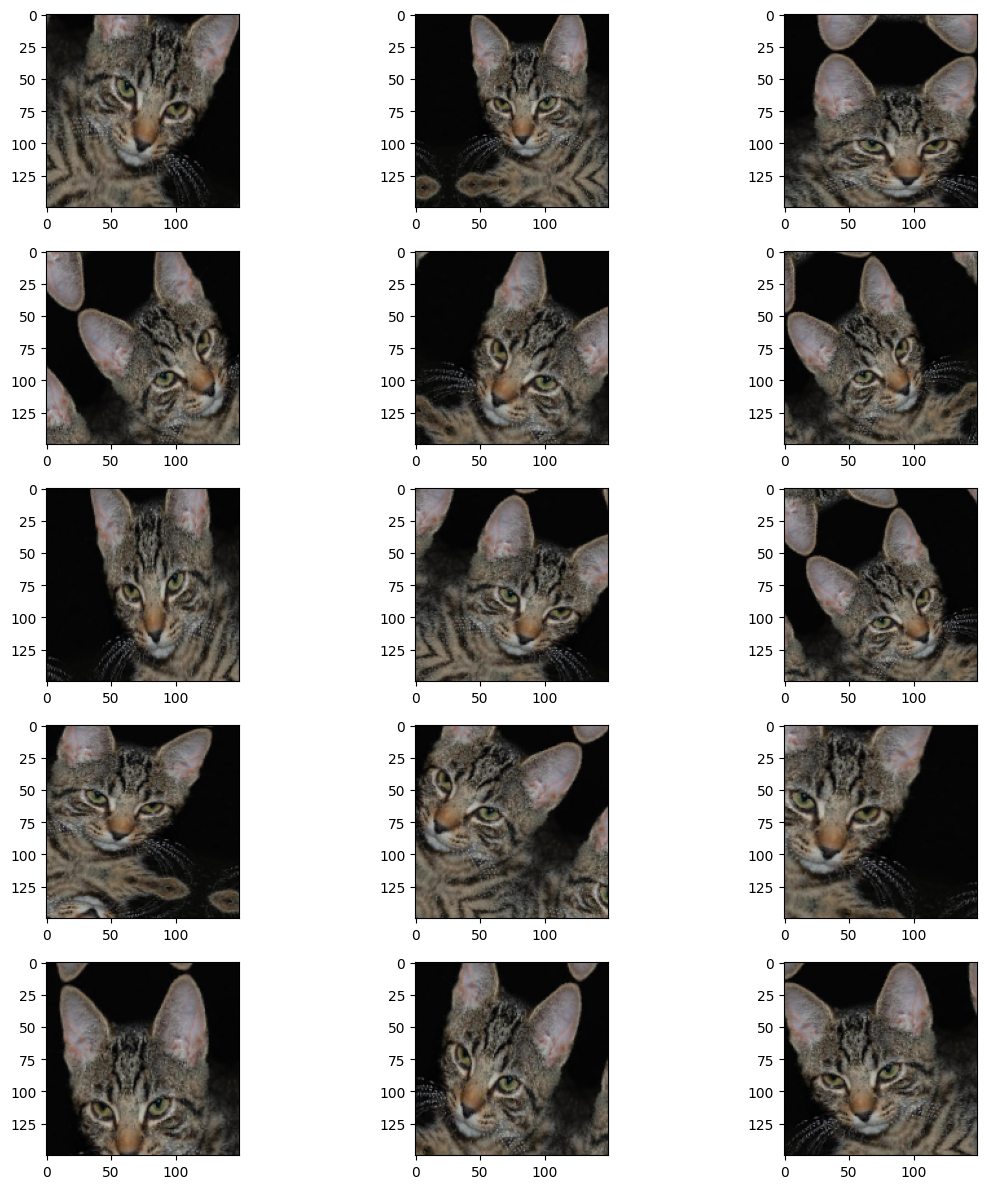

In [10]:
#creating a new figure with a specified size for the plot
plt.figure(figsize=(12, 12))
for i in range(0, 15): #looping through a range to display 15 example images
    #creating subplots with 5 rows and 3 columns, and indexing starts from 1
    plt.subplot(5, 3, i+1)
    #iterating over batches of images and labels from the example generator
    for X_batch, Y_batch in example_generator:
        image = X_batch[0] #extracting the first image from the batch
        plt.imshow(image) #displaying the image
        #exiting the loop after displaying the first image in the batch
        break
plt.tight_layout() #adjusting the layout of the subplots to make them fit nicely
plt.show() #displaying the plot

## Validation Data Generator

In [11]:
#creating an ImageDataGenerator for validation data with rescaling
validation_datagen = ImageDataGenerator(rescale=1./255)  
#rescale pixel values to the range [0, 1] for validation data

#creating a data generator for the validation data
validation_generator = validation_datagen.flow_from_dataframe(  
    df_validation,  #dataFrame containing the validation data
    "/kaggle/input/animal-faces/afhq/train/",  #directory where the validation images are located
    x_col='filename',  #column in DataFrame that contains the filenames of the validation images
    y_col='class',  #column in DataFrame that contains the class labels of the validation images
    target_size=(150, 150),  #resize all validation images to 150x150 pixels
    class_mode='categorical',  #return class labels as one-hot encoded vectors
    batch_size=64  #number of images to return in each batch
)

Found 2926 validated image filenames belonging to 3 classes.


***
# Building the Convolutional Neural Networks (CNNs) model

In [12]:
model = Sequential()  #creating a Sequential model
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))  #adding a convolutional layer with 32 filters, each of size 3x3, using ReLU activation function
model.add(BatchNormalization())  #batch normalization layer to normalize the activations of the previous layer
model.add(MaxPooling2D(pool_size=(2, 2)))  #adding a max pooling layer with a pool size of 2x2
model.add(Dropout(0.25))  #adding a dropout layer to prevent overfitting
model.add(Conv2D(64, (3, 3), activation='relu'))  #adding another convolutional layer with 64 filters, each of size 3x3, using ReLU activation function
model.add(BatchNormalization())  #batch normalization layer
model.add(MaxPooling2D(pool_size=(2, 2)))  #max pooling layer
model.add(Dropout(0.25))  #dropout layer
model.add(Conv2D(128, (3, 3), activation='relu'))  #adding another convolutional layer with 128 filters, each of size 3x3, using ReLU activation function
model.add(BatchNormalization())  #batch normalization layer
model.add(MaxPooling2D(pool_size=(2, 2)))  #max pooling layer
model.add(Dropout(0.25))  #dropout layer
model.add(Flatten())  #flattening the output of the previous layer
model.add(Dense(512, activation='relu'))  #adding a fully connected layer with 512 units and ReLU activation function
model.add(BatchNormalization())  #batch normalization layer
model.add(Dropout(0.5))  #dropout layer
model.add(Dense(3, activation='softmax'))  #adding the output layer with 3 units and softmax activation function for multi-class classification
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])  #compiling the model with categorical crossentropy loss function, RMSprop optimizer, and accuracy metric
model.summary() #displaying a summary of the model architecture

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 148, 148, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 74, 74, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 72, 72, 64)        2

In [13]:
#defining an EarlyStopping callback to stop training if the validation loss doesn't improve for 10 epochs
early_stopping = EarlyStopping(patience=10)  
#defining a ReduceLROnPlateau callback to reduce the learning rate if the validation accuracy doesn't improve for 3 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_acc', patience=3, factor=0.5, min_lr=0.00001)  
#combining the callbacks into a list
callbacks = [early_stopping, reduce_lr]  

***
# Training the model

<code style="color:darkblue">In every train dataset cat, dog and wild we have around 821 pictures that are called flickr_cat, flickr_dog or flickr_wild and around 4834 pixabay_cat, pixabay_dog or pixabay_wild. Overall in the dataset I have around 5655 images for cat, around 5655 images for dog and around 5655 images for wild animal. Every image has 512×512 resolution. </code>

In [14]:
#training the model using the fit() method
history = model.fit(  
    train_generator,  #training data generator
    epochs=100,  #number of epochs to train the model
    validation_data=validation_generator,  #validation data generator
    callbacks=callbacks  #list of callbacks for monitoring the training process
)

Epoch 1/100


2024-06-13 21:09:34.949337: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1718312979.971483      75 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


183/183 [==============================] - 192s 1s/step - loss: 1.1100 - accuracy: 0.6059 - val_loss: 1.6730 - val_accuracy: 0.5284 - lr: 0.0010
Epoch 2/100
183/183 [==============================] - 89s 484ms/step - loss: 0.5949 - accuracy: 0.7659 - val_loss: 1.3683 - val_accuracy: 0.4904 - lr: 0.0010
Epoch 3/100
183/183 [==============================] - 87s 477ms/step - loss: 0.4290 - accuracy: 0.8339 - val_loss: 0.3917 - val_accuracy: 0.8407 - lr: 0.0010
Epoch 4/100
183/183 [==============================] - 87s 477ms/step - loss: 0.3538 - accuracy: 0.8641 - val_loss: 0.3627 - val_accuracy: 0.8575 - lr: 0.0010
Epoch 5/100
183/183 [==============================] - 87s 475ms/step - loss: 0.3014 - accuracy: 0.8873 - val_loss: 0.4064 - val_accuracy: 0.8650 - lr: 0.0010
Epoch 6/100
183/183 [==============================] - 86s 472ms/step - loss: 0.2673 - accuracy: 0.9008 - val_loss: 0.6546 - val_accuracy: 0.7881 - lr: 0.0010
Epoch 7/100
183/183 [==============================] - 88s 4

***
# Evaluating the model

## Test Data Generator

In [15]:
#creating an ImageDataGenerator for test data with rescaling
test_gen = ImageDataGenerator(rescale=1./255)  
#rescale pixel values to the range [0, 1] for test data

#creating a data generator for the test data
test_generator = test_gen.flow_from_dataframe(  
    df_test,  #dataFrame containing the test data
    "/kaggle/input/animal-faces/afhq/train/",  #directory where the test images are located
    x_col='filename',  #column in DataFrame that contains the filenames of the test images
    y_col=None,  #no class labels are provided for the test images
    class_mode=None,  #no class mode is specified since there are no class labels
    target_size=(150, 150),  #resize all test images to 150x150 pixels
    batch_size=64,  #number of images to return in each batch
    shuffle=False  #do not shuffle the order of the images in the test dataset
)

Found 14630 validated image filenames.


## Making Predictions

In [16]:
#making predictions on the test data using the trained model
predict = model.predict(  
    test_generator,  #test data generator
    steps=int(np.ceil(df_test.shape[0] / 64))  #number of steps (batches) to iterate over the test data
)

229/229 [==============================] - 39s 170ms/step


In [17]:
#adding a new column 'prediction' to the test DataFrame containing the index of the highest predicted probability for each image
df_test['prediction'] = np.argmax(predict, axis=-1)  
#creating a dictionary to map numerical labels to their corresponding class names
label_map = dict((v,k) for k,v in train_generator.class_indices.items())  
#replacing the numerical predictions with their corresponding class names using the label_map dictionary
df_test['prediction'] = df_test['prediction'].replace(label_map)  
#converting class names to their respective numeric labels
df_test['prediction'] = df_test['prediction'].replace({'2': 2, '1': 1})  

In [18]:
#adding a new column 'correctPred' to the test DataFrame
df_test['correctPred'] = df_test.apply(lambda x: str(x['class']) == str(x['prediction']), axis=1)

## Evaluation Visualization

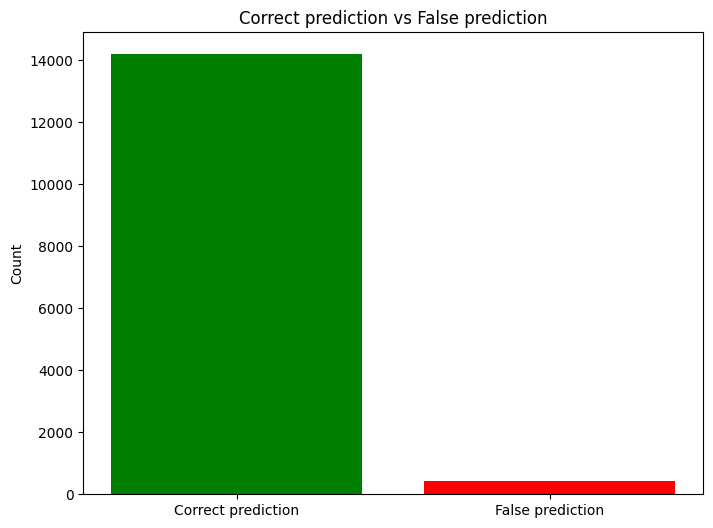

In [19]:
import matplotlib.pyplot as plt  #importing the matplotlib library for plotting
correct_pred_counts = df_test['correctPred'].value_counts()  #counting correct and false predictions
plt.figure(figsize=(8, 6))  #creating a new figure for the plot with specified size
plt.bar(['Correct prediction', 'False prediction'], correct_pred_counts, color=['green', 'red'])  #creating a bar plot with correct and false prediction counts, specifying colors for each bar
plt.title('Correct prediction vs False prediction')  #adding a title to the plot
plt.ylabel('Count')  #adding a label to the y-axis
plt.show() #displaying the plot

## Random Sample Predictions Visualization

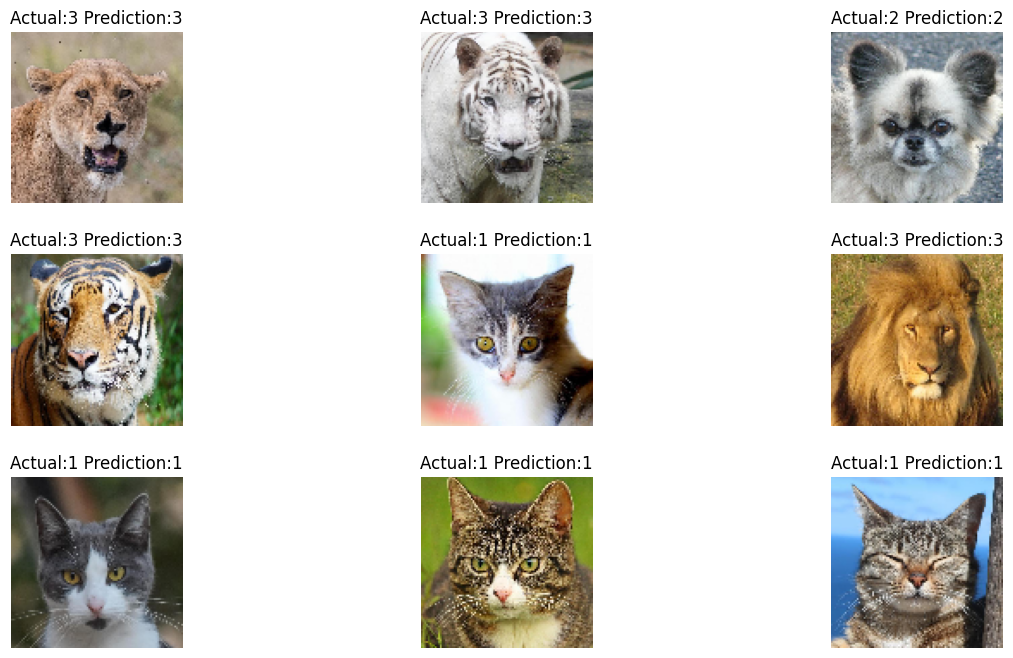

In [20]:
import random  #importing the random module for generating random indices
import matplotlib.pyplot as plt  #importing matplotlib for plotting
import matplotlib.gridspec as gridspec  #importing gridspec for creating a grid layout
from tensorflow.keras.preprocessing.image import load_img  #importing load_img function to load images

#generate random indices
randomlist = []  #initialize an empty list to store random indices
for i in range(9):  #loop 9 times to generate 9 random indices
    n = random.randint(0, len(df_test) - 1)  #generate a random index within the range of the DataFrame
    randomlist.append(n)  #append the random index to the list
#create a figure and grid spec
fig = plt.figure(figsize=(15, 8))  #create a new figure with specified size
gs1 = gridspec.GridSpec(3, 3)  #create a 3x3 grid layout for subplots

#create subplots and display images
for num, idx in enumerate(randomlist):  #iterate over the random indices and their corresponding numbers
    row = df_test.iloc[idx]  #get the row corresponding to the random index
    filename = row['filename']  #get the filename of the image
    img = load_img(f"/kaggle/input/animal-faces/afhq/train/{filename}", target_size=(100, 100))  #load and resize the image
    ax = fig.add_subplot(gs1[num])  #add a subplot to the figure at the current grid position
    ax.imshow(img)  #display the image
    ax.set_title(f"Actual:{row['class']} Prediction:{row['prediction']}")  #set title with actual class and model prediction
    ax.axis('off')  #turn off axis labels

#adjust the layout
fig.subplots_adjust(hspace=0.3)  #adjust the spacing between subplots
plt.show()  #display the plot

In [21]:
#mapping numerical class labels to their corresponding class names
class_mapping = {"1": "cat", "2": "dog", "3": "wild"}
#replacing numerical class labels in the 'class' column with their corresponding class names
df_test['class'].replace(class_mapping, inplace=True)
#getting unique values in the 'prediction' column
unique_predictions = df_test['prediction'].unique()

In [22]:
#corrected class mapping with keys matching the values in the 'prediction' column
class_mapping = {"1": "cat", "2": "dog", "3": "wild"}
#replacing numerical class labels in the 'prediction' column with their corresponding class names
df_test['prediction'].replace(class_mapping, inplace=True)

In [23]:
df_test

,filename,class,prediction,correctPred
0,cat/pixabay_cat_000354.jpg,cat,1,True
1,cat/pixabay_cat_002763.jpg,cat,1,True
2,cat/pixabay_cat_001283.jpg,cat,1,True
3,cat/pixabay_cat_003423.jpg,cat,1,True
4,cat/flickr_cat_000496.jpg,cat,1,True
...,...,...,...,...
14625,wild/pixabay_wild_000618.jpg,wild,wild,True
14626,wild/pixabay_wild_000552.jpg,wild,wild,True
14627,wild/flickr_wild_002275.jpg,wild,wild,True
14628,wild/pixabay_wild_000484.jpg,wild,wild,True


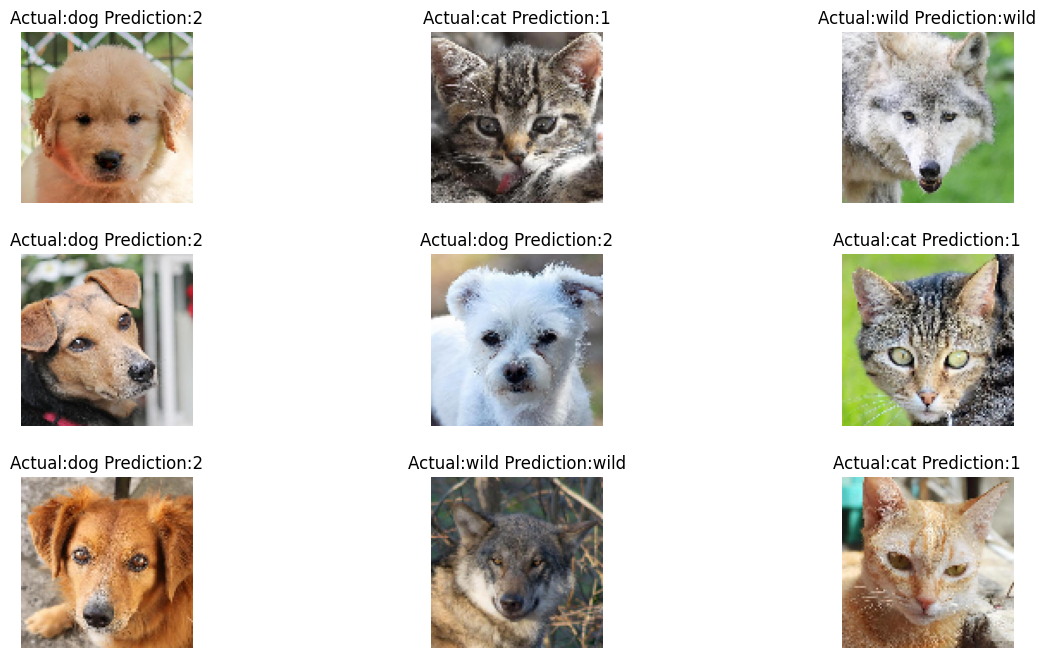

In [24]:
import random  #importing the random module for generating random indices
import matplotlib.pyplot as plt  #importing matplotlib for plotting
import matplotlib.gridspec as gridspec  #importing gridspec for creating a grid layout
from tensorflow.keras.preprocessing.image import load_img  #importing load_img function to load images

#generate random indices
randomlist = []  #initialize an empty list to store random indices
for i in range(9):  #loop 9 times to generate 9 random indices
    n = random.randint(0, len(df_test) - 1)  #generate a random index within the range of the DataFrame
    randomlist.append(n)  #append the random index to the list

#create a figure and grid spec
fig = plt.figure(figsize=(15, 8))  #create a new figure with specified size
gs1 = gridspec.GridSpec(3, 3)  #create a 3x3 grid layout for subplots

#create subplots and display images
for num, idx in enumerate(randomlist):  #iterate over the random indices and their corresponding numbers
    row = df_test.iloc[idx]  #get the row corresponding to the random index
    filename = row['filename']  #get the filename of the image
    img = load_img(f"/kaggle/input/animal-faces/afhq/train/{filename}", target_size=(100, 100))  #load and resize the image
    ax = fig.add_subplot(gs1[num])  #add a subplot to the figure at the current grid position
    ax.imshow(img)  #display the image
    ax.set_title(f"Actual:{row['class']} Prediction:{row['prediction']}")  #set title with actual class and model prediction
    ax.axis('off')  #turn off axis labels

#adjust the layout
fig.subplots_adjust(hspace=0.3)  #adjust the spacing between subplots
plt.show()  #display the plot